In [ ]:
# Import
import numpy as np

# For table formatting
import locale 
from tabulate import tabulate

# For graphs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# For PDF
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.platypus import Table, TableStyle, SimpleDocTemplate

#from reportlab.lib.units import cm
#from decimal import Decimal, getcontext
#from typing import List, Tuple


class Loan:
    def __init__(self, capital: int, annual_rate: float, years: int, periods_per_year: int):
        """
        Initialize the Loan object with the necessary parameters.

        Args:
            capital (int): The principal amount of the loan.
            annual_rate (float): The annual interest rate in decimal format (e.g., 0.03 for 3%).
            years (int): The number of years for the loan.
            periods_per_year (int): The number of payment periods per year.
        """
        self.capital = capital
        self.annual_rate = annual_rate
        self.years = years
        self.periods_per_year = periods_per_year
        self.nper = years * periods_per_year  # Total number of payments
        self.periodic_rate = annual_rate / periods_per_year  # Periodic interest rate
        self.pmt = -1 * ( (self.capital * self.periodic_rate) / (1 - (1 + self.periodic_rate) ** (-self.nper)) )
        

    def get_ipmt(self, period: int) -> float:
        """
        Calculate the interest payment for a specific period.

        Args:
            period (int): The payment period number.

        Returns:
            float: The interest payment for the given period.
        """
        
        ipmt = -(self.pmt * ((1 + self.periodic_rate) ** (period - 1) - 1) / self.periodic_rate +
                 self.capital * (1 + self.periodic_rate) ** (period - 1)) * self.periodic_rate
        
        return ipmt
    

    def get_ppmt(self, period: int) -> float:
        """
        Calculate the principal payment for a specific period.

        Args:
            period (int): The payment period number.

        Returns:
            float: The principal payment for the given period.
        """
        
        ppmt_a =  (self.pmt * ( (1 + self.periodic_rate)**(period-1) - 1 ) / self.periodic_rate + self.capital * (1 + self.periodic_rate)**(period-1))
        ppmt = self.pmt + ppmt_a  * self.periodic_rate
        
        return ppmt

    

    def get_loan_schedule(self) -> tuple[list[int], list[float], list[float], list[float]]:
        """
        Generate the loan amortization schedule.

        Returns:
            tuple: A tuple containing lists of periods, interest payments, principal payments, and total payments.
        """
        list_per = []
        list_ipmt = []
        list_ppmt = []
        list_pmt = []

        for i in range(1, self.nper + 1):
            ipmt = self.get_ipmt(i)
            ppmt = self.get_ppmt(i)
            pmt = self.pmt

            list_per.append(i)
            list_ipmt.append(-ipmt)
            list_ppmt.append(-ppmt)
            list_pmt.append(-pmt)

        return list_per, list_ipmt, list_ppmt, list_pmt


    def get_basic_info(self):
        """ Return the basic parameters of the loan
        
        """
        
        print('Capital : ', self.capital)
        print('Annual rate : ', self.annual_rate)
        print('Number of years : ',self.years)
        print('Number of periods per year : ',self.periods_per_year)
        print('Total number of payments : ',self.nper)
        print('Periodic rate : ',self.periodic_rate)
        print('Periodic payment : ',self.pmt)
        print('Total interest paid : ')
        
        
    def get_period_for_targeted_cumulated_interest(self, threshold:float=0.5):
        """ Return the period number corresponding a cumulated target value

        Args:
            - per (list): list of period
            - ipmt (list): list of periodic interest
            - threshold (float, optional): share of interests already paid (cumulative). Defaults to 0.5.

        Returns:
            int: period when cumulated interest goes beyond the threshold
        """
        
        list_period, list_ipmt, _, _ = self.get_loan_schedule()
        
        ipmt_target = np.sum(list_ipmt) * threshold
        ipmt_cum = np.cumsum(list_ipmt)
        
        for p, i in zip(list_period, ipmt_cum):
            
            if i > ipmt_target:
                result = p
                break
        
        return result


    def get_summary(self):
        """ Return the main charateristics of the loan at a given period number.
            This summary wil be used for the first table of the PDF file.
        Args:
            none
        Returns:
            a list of list representing a list of table rows.
        """
        
        # Initialization of the main list
        table_list = []           
        
        
        try : 
            
            # Static variables that requires some formatting (to have clearer code)
            capital = self.capital 
            annual_rate = str( np.round(self.annual_rate * 100, 2) ) + " %" 
            periods_per_year = self.periods_per_year 
            
            # Get calculated values
            list_period, list_ipmt, list_ppmt, list_pmt = self.get_loan_schedule()
             
            # Calculated variable that requires some formatting (to have clearer code)
            total_interest_paid = '{:,.2f}'.format( np.round( np.sum(list_ipmt),2) )
            total_capital_paid = '{:,.2f}'.format( np.round(np.sum(list_ppmt),2) )
            total_paid = '{:,.2f}'.format( np.round(np.sum(list_pmt), 2) )
            
            # Built list
            table_list.append( ["Main characteristics", "Value"] )
            table_list.append( ["Capital : ", capital] )
            table_list.append( ["Annual interest rate : ", annual_rate] )
            table_list.append( ["Number of years : ", self.years] )
            table_list.append( ["Number of payment per year : ", self.periods_per_year] )
            table_list.append( ["Total number of payments : ", self.nper] )
            table_list.append( ["Total interest paid : ", total_interest_paid] )
            table_list.append( ["Total capital paid : ", total_capital_paid] )
            table_list.append( ["Total paid : ", total_paid] )
        
            return table_list
        
        except UnboundLocalError as e1:
            return print(e1)

            
            
    def get_situation_at_period(self, period:int=1):
        """ Return the main charateristics of the loan at a given period number

        Args:
            - per (list): list of period

        Returns:
            str: 
        """
        
        list_period, list_ipmt, list_ppmt, list_pmt = self.get_loan_schedule()
        
        try : 
            
            # Find the index corresponding to the period entered
            for i, per in enumerate(list_period):
                if list_period[i] == period:
                    period_idx = i  
            
            
            # Situation at period
            period_at_period = list_period[period_idx]
            ipmt_sum_at_period = np.sum(list_ipmt[:period_idx+1]) 
            ppmt_sum_at_period = np.sum(list_ppmt[:period_idx+1]) 
            pmt_sum_at_period = np.sum(list_pmt[:period_idx+1]) 
            
            # Total of series
            period_max = max(list_period)
            ipmt_sum_total = np.sum(list_ipmt) 
            ppmt_sum_total = np.sum(list_ppmt) 
            pmt_sum_total = np.sum(list_pmt) 
            
            # Display results
            print('Situation of loan at period : ', period_at_period)
            print('Paid capital : ',np.round(ppmt_sum_at_period,2))
            print('Paid interest : ', np.round(ipmt_sum_at_period, 2))
            print('cumulated Payment at period : ', np.round(pmt_sum_at_period,2) )
            print('Remaining Period : ', period_max - period_at_period)
            print('Remaining capital :', np.round( ppmt_sum_total - ppmt_sum_at_period,2))
            print('Remaining interest :', np.round(ipmt_sum_total - ipmt_sum_at_period,2))
            print('Remaining payment :', np.round(pmt_sum_total - pmt_sum_at_period,2) )
            print('total capital :', np.round( ppmt_sum_total,2))
        
        except UnboundLocalError as e1:
            return print('Uncorrect period, available periods are : [', min(list_period),',', max(list_period), ']')


    def get_formated_depreciation_table(self, table_size:int=12):
        """ Return a formated depreciation schedule

        Args:
            - per (list): list of periods
            - ipmt (list): list of periodic interests
            - ppmt (list): list of periodic capital
            - pmt (list): list of periodic payments
            - table_size (int, optional): number of periods used to split the table. Defaults to 12.

        Returns:
            table: formated depreciation table
        """
        
        # To use default Operating Système regional settings
        locale.setlocale(locale.LC_ALL, '')
        
        
        # temp
        per, ipmt, ppmt, pmt = self.get_loan_schedule()
        
        # Headers
        headers_FR = ["Echéance", "Mensualité\néchéance", "Capital\néchéance", "Intérêts\néchéance", "Capital\ncumulé", "Intérêts\ncumulé", "Capital\nrestant", "Intérêts\nrestants"]
        headers_ENG = ["Period", "Payment\nPeriodic", "Principal\nPeriodic", "Interest\nPeriodic", "Principal\nCumulated", "Interest\nCumulated", "Principal\nremaining", "Interest\nremaining"]

        
        # First Initialization of the list
        loan_table = []

        # Table size definition
        list_per_cut = np.arange(0, np.max(per), table_size)
        period_start = 0
        period_end = 0
        
        # Loop
        for i in range(min(per), max(per) ):
            
            period_start = period_end
            
            periodic_payment = pmt[i]
            principal_periodic = ppmt[i]
            interest_periodic = ipmt[i]
            principal_cumulated = np.sum(ppmt[:i+1])
            interest_cumulated = np.sum(ipmt[:i+1])
            principal_remaining = np.sum(ppmt) - principal_cumulated
            interest_remaining = np.sum(ipmt) - interest_cumulated

            # Built of the periodic line
            periodic_line = [
                i, 
                locale._format('%.2f', periodic_payment ),
                locale._format('%.2f', principal_periodic ),
                locale._format('%.2f', interest_periodic ),
                locale._format('%.2f', principal_cumulated ),
                locale._format('%.2f', interest_cumulated ),
                locale._format('%.2f', principal_remaining ),
                locale._format('%.2f', interest_remaining )
                ]
            
            if not i in list_per_cut:

                # Add of the periodic line inside the table
                loan_table.append(periodic_line)
                
                
            if i in list_per_cut:
                
                period_end = i
                
                # Add of the periodic line inside the table
                loan_table.append(periodic_line)

                print(tabulate(loan_table, headers = headers_FR, tablefmt="fancy_grid"))
                print("Total périodes : ",period_start, " - ", period_end, '-' * 78)
                print("Capital cumulé : ", locale._format('%.2f', principal_cumulated ))
                print("Intérêts cumulés : ", locale._format('%.2f', interest_cumulated ))
                print('-' * 105)
                print(" ")
                
                loan_table = []

        return "End"
    
    
    def drawMyRuler(self, pdf):
        """Display landmark to ease object placement in PDF page

        Args:
            pdf (object): pdf document
        """
        
        pdf.drawString(100,810, 'x100')
        pdf.drawString(200,810, 'x200')
        pdf.drawString(300,810, 'x300')
        pdf.drawString(400,810, 'x400')
        pdf.drawString(500,810, 'x500')

        pdf.drawString(10,100, 'y100')
        pdf.drawString(10,200, 'y200')
        pdf.drawString(10,300, 'y300')
        pdf.drawString(10,400, 'y400')
        pdf.drawString(10,500, 'y500')
        pdf.drawString(10,600, 'y600')
        pdf.drawString(10,700, 'y700')
        pdf.drawString(10,800, 'y800')    
    
    
    
    def draw_graph(self, filename:str='my-graph.png'):
        """ Draw a graph of periodic figures

        Args:
            none
            
        return : graph
        """
        
        # Parameters
        mpl.rcParams["font.size"] = 16
        colors = ['#85c1e9', '#f8c471']
        
        
        # Main data
        list_period, list_ipmt, list_ppmt, list_pmt = self.get_loan_schedule()
        
        ipmt_max = int(np.round(np.sum(list_ipmt)))
        ppmt_max = int(np.round(np.sum(list_ppmt)))
        ipmt_25 = int(np.round(ipmt_max * 0.25 , 0))
        ipmt_50 = int(np.round(ipmt_max * 0.5 , 0))
        ipmt_75 = int(np.round(ipmt_max * 0.75 , 0))
        ppmt_25 = int(np.round(ppmt_max * 0.25 , 0))
        ppmt_50 = int(np.round(ppmt_max * 0.50 , 0))
        ppmt_75 = int(np.round(ppmt_max * 0.75 , 0))

        period_for_cum_ipmt_25 = self.get_period_for_targeted_cumulated_interest(0.25) 
        period_for_cum_ipmt_50 = self.get_period_for_targeted_cumulated_interest(0.5) 
        period_for_cum_ipmt_75 = self.get_period_for_targeted_cumulated_interest(0.75) 

        # Graph
        fig, ax = plt.subplots(figsize=(12,10))

        ax.plot(np.cumsum(list_ipmt), label='Cumulated interest', alpha=0.5, linewidth=4, color=colors[1])
        ax.plot(np.cumsum(list_ppmt), label='Cumulated capital', alpha=0.8, linewidth=4, color=colors[0])
        
        ax.axvline(x = period_for_cum_ipmt_25, color='#D3D3D3', linestyle='--')
        ax.axvline(x = period_for_cum_ipmt_50, color='#D3D3D3', linestyle='--')
        ax.axvline(x = period_for_cum_ipmt_75, color='#D3D3D3', linestyle='--')
        
        text_25 = '25 % of interests are paid on period {}'.format(period_for_cum_ipmt_25)
        text_50 = '50 % of interests are paid on period {}'.format(period_for_cum_ipmt_50)
        text_75 = '75 % of interests are paid on period {}'.format(period_for_cum_ipmt_75)
        
        ax.annotate(text_25, 
                    (period_for_cum_ipmt_25, ppmt_25), 
                    size=14, 
                    color='white', 
                    weight='normal', 
                    bbox=dict(boxstyle='round', color=colors[1], pad=0.3, alpha=0.8)
                    )
        
        ax.annotate(text_50, 
                    (period_for_cum_ipmt_50, ppmt_50), 
                    size=14, 
                    color='white', 
                    weight='normal', 
                    bbox=dict(boxstyle='round', color=colors[1], pad=0.3, alpha=0.8)
                    )
        
        ax.annotate(text_75, 
                    (period_for_cum_ipmt_75, ppmt_75), 
                    size=14, 
                    color='white', 
                    weight='normal', 
                    bbox=dict(boxstyle='round', color=colors[1], pad=0.3, alpha=0.8)
                    )

        plt.xlabel('Periods')
        plt.ylabel('Amount')
        plt.legend()
        plt.title('Loan composition over time')
        plt.savefig(filename)
        
    
    
    
    def generate_summary_pdf(self, table_size:int=12, FileName: str = "loan_summary.pdf"):
        """
        Generate a PDF summary of the loan details.
        
        Args:
            filename (str): Output PDF filename. Defaults to "loan_summary.pdf".
        """


        # To use default Operating Système regional settings
        locale.setlocale(locale.LC_ALL, '')
        
        
        # Headers
        headers_ENG = ["Period", "Payment\nPeriodic", "Principal\nPeriodic", "Interest\nPeriodic", "Principal\nCumulated", "Interest\nCumulated", "Principal\nremaining", "Interest\nremaining"]


        # Main data
        list_period, list_ipmt, list_ppmt, list_pmt = self.get_loan_schedule()
        
        # First Initialization of the list
        loan_table = []
        loan_table.append(headers_ENG)
        table_counter = 1
        

        # Table size definition
        period_chunk_list = np.arange(0, np.max(list_period), table_size).tolist()
        period_chunk_list.pop(0)
        
        
        # Add of the last period in the case number of period is not a multiple of table_size
        if np.max(list_period) > np.max(period_chunk_list):
            period_chunk_list.append((np.max(list_period)).tolist())
        
        
        table_counter = 0
        table_dict = {}
        
        
        period_min = min(list_period) 
        period_max = max(list_period) +1
        
        
        #---------------------------------------------------------------------------------------#
        #----------------------- Create a dictionary of tables ---------------------------------#
        #---------------------------------------------------------------------------------------# 
                   
                   
        # Loop to build tables
        for idx in range( period_min, period_max ):
            
            i = idx -1
            
            period = list_period[i]
            periodic_payment = list_pmt[i]
            principal_periodic = list_ppmt[i]
            interest_periodic = list_ipmt[i]
            principal_cumulated = np.sum(list_ppmt[:i+1])
            interest_cumulated = np.sum(list_ipmt[:i+1])
            principal_remaining = np.sum(list_ppmt) - principal_cumulated
            interest_remaining = np.sum(list_ipmt) - interest_cumulated

        
            # Built of the periodic line
            periodic_line = [
                period, 
                '{:,.2f}'.format( periodic_payment),
                '{:,.2f}'.format( principal_periodic),
                '{:,.2f}'.format( interest_periodic),
                '{:,.2f}'.format( principal_cumulated),
                '{:,.2f}'.format( interest_cumulated),
                '{:,.2f}'.format( principal_remaining),
                '{:,.2f}'.format( interest_remaining)
                ]
             
            if not idx in period_chunk_list:

                # Add of the periodic line inside the table
                loan_table.append(periodic_line)
                
                
            if idx in period_chunk_list:
        
                # Add of the periodic line inside the table
                loan_table.append(periodic_line)
                
                table_dict[table_counter] = loan_table
                table_counter += 1
                
                loan_table = []
                loan_table.append(headers_ENG)        


        #---------------------------------------------------------------------------------------#
        #----------------------- Generate PDF --------------------------------------------------#
        #---------------------------------------------------------------------------------------# 


        # Create a PDF canvas
        pdf = canvas.Canvas(filename=FileName, pagesize=A4)
        width, height = A4
        pdf.setTitle(FileName)
        
        
        # Pages number definition
        current_page = 1
        
        if max(table_dict.keys()) % 2 == 0:
            last_page = int(current_page + max(table_dict.keys()) / 2 + 1)
        else:
            last_page = int(current_page + max(table_dict.keys()) // 2 + 2)
        
        
        # Temp : utils for design phase
        # print("width, height : ",width, height)
        # loan.drawMyRuler(pdf)
        

        # Format of the table
        style_01 = TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (1, 0), 'CENTER'), # Header
            ('ALIGN', (0, 1), (0, -1), 'LEFT'), # First column
            ('ALIGN', (1, 1), (1, -1), 'CENTER'), # Second column
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('FONTSIZE', (0, 0), (-1, 0), 10),
            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
            ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
            ('GRID', (0, 0), (-1, -1), 1, colors.black)
            ])  
        
        style_02 = TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('FONTSIZE', (0, 0), (-1, 0), 10),
            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
            ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
            ('GRID', (0, 0), (-1, -1), 1, colors.black)
            ])  


        # First page header
        pdf.setFont("Helvetica-Bold", 16)
        pdf.drawCentredString(width/2, height-75, "Loan Amortization Schedule")
        

        # First page : display summary
        pdf.setFont("Helvetica-Bold", 12)
        pdf.drawString(75, height-150, "Summary of loan")
        pdf.setFont("Helvetica", 12)
        
        summary_list = self.get_summary()
        summary_table = Table(summary_list)
        summary_table.setStyle(style_01)
        summary_table.wrapOn(pdf, aW = width, aH = height)
        summary_table.drawOn(pdf, x = 75, y = 500)


        # First page : display graph
        graph_name = 'loan-graph.png'
        self.draw_graph(filename=graph_name)
        pdf.drawImage(graph_name, x = 25, y = height-750, width = width-50, height = 400)
        
        
        # Add page number
        pdf.drawRightString(width-25, height-810, f"Page {current_page} / {last_page}")


        # From second page to last page : loop to display 2 tables per page
        for table_id in table_dict.keys():
            
            if table_id % 2 == 0:
                table = Table(table_dict[table_id])
                table.setStyle(style_02)
        
                # Change page
                pdf.showPage()
                current_page += 1
                    
                # Draw the table
                table.wrapOn(pdf, aW = width, aH = height)
                table.drawOn(pdf, x=75, y=500)
                
                # Add page number
                pdf.drawRightString(width-50, height-810, f"Page {current_page} / {last_page}") 
                
            else :
                table = Table(table_dict[table_id])
                table.setStyle(style_02)
                
                # Draw the table
                table.wrapOn(pdf, aW = width, aH = height)
                table.drawOn(pdf, x=75, y=200)
                        

        # Save the PDF
        pdf.save()
              

In [2]:
c1 = 100000 # Capital
r1 = 0.0300 # Annual Interest rate
fper1 = 12 # Number of periodic payments (number of months per year)
per1 = 25 # Number of years 
n1 = 300 # Specific period 

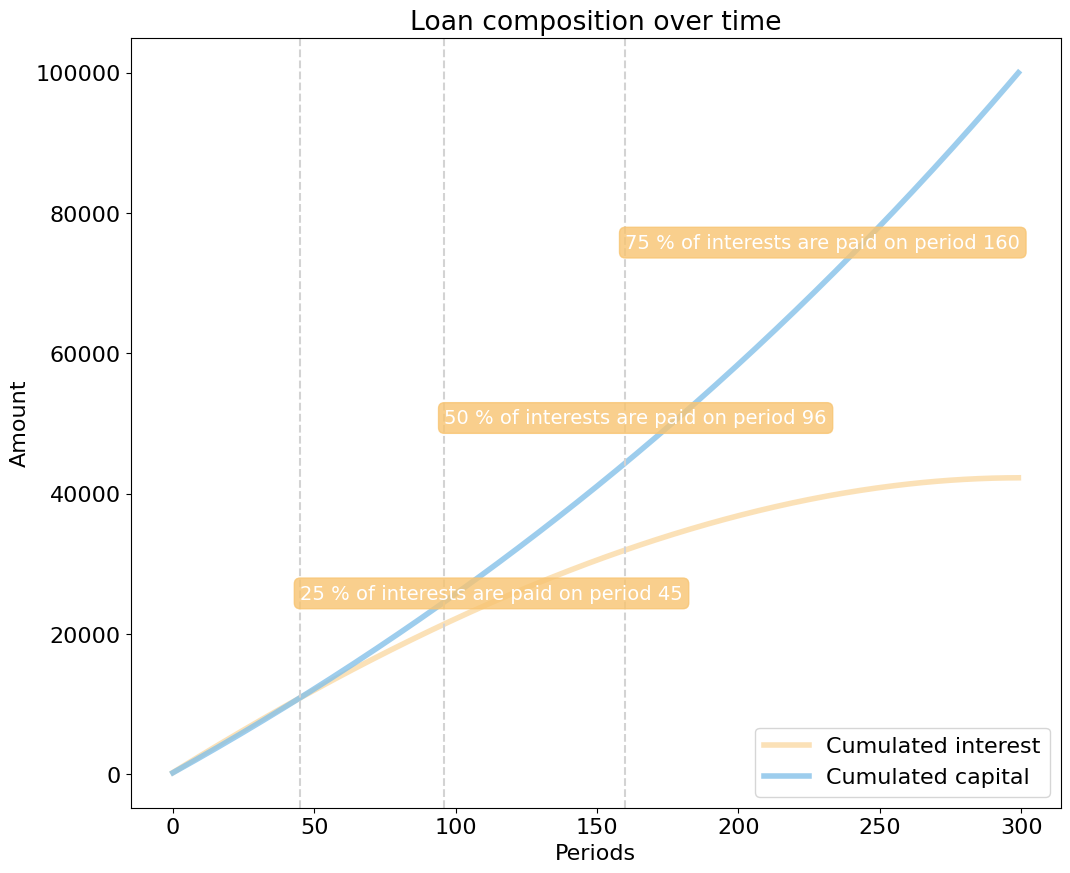

In [8]:
loan = Loan(capital= c1, annual_rate= r1, years= per1, periods_per_year=fper1)
# dir(loan)
# loan.get_basic_info()
# print(30*'-')
# loan.get_period_for_targeted_cumulated_interest(threshold=0.5)
# print(30*'-')
# loan.get_situation_at_period(period=300)
# loan.get_formated_depreciation_table()
# loan.get_summary()
# loan.draw_graph()
loan.generate_summary_pdf(FileName= "loan_summary.pdf",  table_size=12)